In [1]:
import pathlib

import numpy as np
from IPython.display import Code

import RATapi as RAT
from RATapi.models import Parameter

# Custom Layers Example for Supported DSPC layer

Example of using Custom layers to model a DSPC supported bilayer.
Start by making the project and setting it to a custom layers type:

In [2]:
problem = RAT.Project(name="Orso lipid example - custom layers", model="custom layers", geometry="substrate/liquid")

For a custom layers model, rather than being forced to define our layers as \[Thick SLD Rough.... etc\], we can parameterise however we like and then use a function to calculate the \[d $\rho$ $\sigma$\] arrangement for each layer. So for example, if the volume of lipid tails are known (from the literature), then all we need is the Area per molecule, because then:

$$
d = \frac{V}{APM},
$$
where d is the thickness and V is the volume.

Likewise, the SLD is:
$$
\rho = \frac{\sum_{i}n_{i}b_{i}}{V},
$$

as usual.

In this folder there is a pre-prepared Python custom model for a DSPC on a Silicon substrate. We can display it here to see what we mean:

In [3]:
Code(filename='custom_bilayer_DSPC.py', language='python')

import numpy as np


def custom_bilayer_DSPC(params, bulk_in, bulk_out, contrast):
    """CUSTOMBILAYER RAT Custom Layer Model File.

    This file accepts 3 vectors containing the values for params, bulk in and bulk out.
    The final parameter is an index of the contrast being calculated.

    The function should output a matrix of layer values, in the form...

    Output = [thick 1, SLD 1, Rough 1, Percent Hydration 1, Hydrate how 1
              ....
              thick n, SLD n, Rough n, Percent Hydration n, Hydration how n]

    The "hydrate how" parameter decides if the layer is hydrated with Bulk out or Bulk in phases.
    Set to 1 for Bulk out, zero for Bulk in.
    Alternatively, leave out hydration and just return...

    Output = [thick 1, SLD 1, Rough 1,
              ....
              thick n, SLD n, Rough n]

    The second output parameter should be the substrate roughness.
    """
    sub_rough = params[0]
    oxide_thick = params[1]
    oxide_hydration = params[2]
    lipidAPM = params[3]
    headHydration = params[4]
    bilayerHydration = params[5]
    bilayerRough = params[6]
    waterThick = params[7]

    # We have a constant SLD for the bilayer
    oxide_SLD = 3.41e-6

    # Now make the lipid layers
    # Use known lipid volume and compositions to make the layers

    # define all the neutron b's.
    bc = 0.6646e-4  # Carbon
    bo = 0.5843e-4  # Oxygen
    bh = -0.3739e-4  # Hydrogen
    bp = 0.513e-4  # Phosphorus
    bn = 0.936e-4  # Nitrogen

    # Now make the lipid groups
    COO = (4 * bo) + (2 * bc)
    GLYC = (3 * bc) + (5 * bh)
    CH3 = (2 * bc) + (6 * bh)
    PO4 = (1 * bp) + (4 * bo)
    CH2 = (1 * bc) + (2 * bh)
    CHOL = (5 * bc) + (12 * bh) + (1 * bn)

    # Group these into heads and tails:
    Head = CHOL + PO4 + GLYC + COO
    Tails = (34 * CH2) + (2 * CH3)

    # We need volumes for each. Use literature values:
    vHead = 319
    vTail = 782

    # We use the volumes to calculate the SLDs
    SLDhead = Head / vHead
    SLDtail = Tails / vTail

    # We calculate the layer thickness' from the volumes and the APM
    headThick = vHead / lipidAPM
    tailThick = vTail / lipidAPM

    # Manually deal with hydration for layers in this example.
    oxSLD = (oxide_hydration * bulk_out[contrast]) + ((1 - oxide_hydration) * oxide_SLD)
    headSLD = (headHydration * bulk_out[contrast]) + ((1 - headHydration) * SLDhead)
    tailSLD = (bilayerHydration * bulk_out[contrast]) + ((1 - bilayerHydration) * SLDtail)

    # Make the layers
    oxide = [oxide_thick, oxSLD, sub_rough]
    water = [waterThick, bulk_out[contrast], bilayerRough]
    head = [headThick, headSLD, bilayerRough]
    tail = [tailThick, tailSLD, bilayerRough]

    output = np.array([oxide, water, head, tail, tail, head])

    return output, sub_rough

We need to add the parameters we are going to need to define the model (note that Substrate Roughness always exists as parameter 0 as before, and that we are setting a Gaussian prior on the Head Hydration here).

In [4]:
parameter_list = [
    Parameter(name="Oxide Thickness", min=5.0, value=20.0, max=60.0, fit=True),
    Parameter(name="Oxide Hydration", min=0.0, value=0.2, max=0.5, fit=True),
    Parameter(name="Lipid APM", min=45.0, value=55.0, max=65.0, fit=True),
    Parameter(name="Head Hydration", min=0.0, value=0.2, max=0.5, fit=True, prior_type='gaussian', mu=0.3, sigma=0.03),
    Parameter(name="Bilayer Hydration", min=0.0, value=0.1, max=0.2, fit=True),
    Parameter(name="Bilayer Roughness", min=2.0, value=4.0, max=8.0, fit=True),
    Parameter(name="Water Thickness", min=0.0, value=2.0, max=10.0, fit=True)
]

problem.parameters.extend(parameter_list)
problem.parameters.set_fields(0, min=1.0, max=10.0)

Need to add the relevant Bulk SLD's. Change the bulk in from air to silicon, and add two additional water contrasts:

In [5]:
# Change the bulk in from air to silicon:
problem.bulk_in.set_fields(0, name="Silicon", min=2.07e-6, value=2.073e-6, max=2.08e-6, fit=False)

problem.bulk_out.append(name="SLD SMW", min=1.0e-6, value=2.073e-6, max=3.0e-6, fit=True)
problem.bulk_out.append(name="SLD H2O", min=-0.6e-6, value=-0.56e-6, max=-0.3e-6, fit=True)

problem.bulk_out.set_fields(0, min=5.0e-6, fit=True)

Now add the datafiles. We have three datasets we need to consider - the bilayer against D2O, Silicon Matched water and H2O. Load these datafiles in and put them in the data block:

In [6]:
# Read in the datafiles
data_path = pathlib.Path("../data")
D2O_data = np.loadtxt(data_path / "c_PLP0016596.dat", delimiter=",")
SMW_data = np.loadtxt(data_path / "c_PLP0016601.dat", delimiter=",")
H2O_data = np.loadtxt(data_path / "c_PLP0016607.dat", delimiter=",")

# Add the data to the project - note this data has a resolution 4th column
problem.data.append(name="Bilayer / D2O", data=D2O_data, data_range=[0.013, 0.37])
problem.data.append(name="Bilayer / SMW", data=SMW_data, data_range=[0.013, 0.32996])
problem.data.append(name="Bilayer / H2O", data=H2O_data, data_range=[0.013, 0.33048])

Add the custom file to the project:

In [7]:
problem.custom_files.append(name="DSPC Model", filename="custom_bilayer_DSPC.py", language="python", path=pathlib.Path.cwd().resolve())

Also, add the relevant background parameters - one each for each contrast:

In [8]:
problem.background_parameters.set_fields(0, name="Background parameter D2O", min=1.0e-10, max=1.0e-5, value=1.0e-07, fit=True)

problem.background_parameters.append(name="Background parameter SMW", min=1.0e-10, value=1.0e-7, max=1.0e-5, fit=True)
problem.background_parameters.append(name="Background parameter H2O", min=1.0e-10, value=1.0e-7, max=1.0e-5, fit=True)

# And add the two new constant backgrounds
problem.backgrounds.append(name="Background SMW", type="constant", source="Background parameter SMW")
problem.backgrounds.append(name="Background H2O", type="constant", source="Background parameter H2O")

# And edit the other one
problem.backgrounds.set_fields(0, name="Background D2O", source="Background parameter D2O")

# Finally modify some of the other parameters to be more suitable values for a solid / liquid experiment
problem.scalefactors.set_fields(0, value=1.0, min=0.5, max=2.0, fit=True)

We need to use the data resolution (i.e. the fourth column of our datafiles). Do do this, we need to add a 'Data' resolution object to our resolutions table

In [9]:
problem.resolutions.append(name="Data Resolution", type="data")

Now add the three contrasts as before:

In [10]:
problem.contrasts.append(
    name="Bilayer / D2O",
    background="Background D2O",
    resolution="Data Resolution",
    scalefactor="Scalefactor 1",
    bulk_out="SLD D2O",
    bulk_in="Silicon",
    data="Bilayer / D2O",
    model=["DSPC Model"],
)

problem.contrasts.append(
    name="Bilayer / SMW",
    background="Background SMW",
    resolution="Data Resolution",
    scalefactor="Scalefactor 1",
    bulk_out="SLD SMW",
    bulk_in="Silicon",
    data="Bilayer / SMW",
    model=["DSPC Model"],
)

problem.contrasts.append(
    name="Bilayer / H2O",
    background="Background H2O",
    resolution="Data Resolution",
    scalefactor="Scalefactor 1",
    bulk_out="SLD H2O",
    bulk_in="Silicon",
    data="Bilayer / H2O",
    model=["DSPC Model"],
)

Note that the model is simply the custom file we've just added to the project.

Look at the complete model definition before sending it to RAT:

In [11]:
print(problem)

Name: ----------------------------------------------------------------------------------------------

Orso lipid example - custom layers

Calculation: ---------------------------------------------------------------------------------------

non polarised

Model: ---------------------------------------------------------------------------------------------

custom layers

Geometry: ------------------------------------------------------------------------------------------

substrate/liquid

Parameters: ----------------------------------------------------------------------------------------

+-------+---------------------+------+-------+------+------+------------+-----+-------+
| index |         name        | min  | value | max  | fit  | prior type |  mu | sigma |
+-------+---------------------+------+-------+------+------+------------+-----+-------+
|   0   | Substrate Roughness | 1.0  |  3.0  | 10.0 | True |  uniform   | 0.0 |  inf  |
|   1   |   Oxide Thickness   | 5.0  |  20.0 | 60.0 | 

To run it, we need to make a controls block

In [12]:
controls = RAT.Controls()
print(controls)

+------------------+-----------+
|     Property     |   Value   |
+------------------+-----------+
|    procedure     | calculate |
|     parallel     |   single  |
| calcSldDuringFit |   False   |
| resampleMinAngle |    0.9    |
| resampleNPoints  |     50    |
|     display      |    iter   |
+------------------+-----------+


. . . and send this to RAT

Starting RAT ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Elapsed time is 0.020 seconds

Finished RAT ───────────────────────────────────────────────────────────────────────────────────────────────────────────



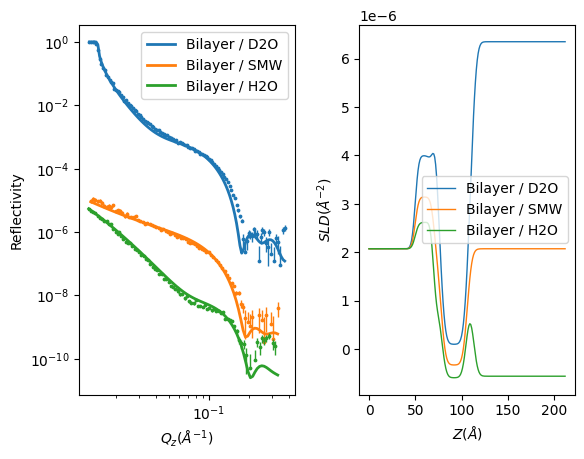

In [13]:
problem, results = RAT.run(problem, controls)
RAT.plotting.plot_ref_sld(problem, results)